### Linear Regression on Abalone Dataset

Read the precomputed scaled data which we saved in "exploratory.ipynb"

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import os

input_path = '../data/abalone'
output_path = '../output'

In [2]:
# read back the files saved previously (uses existing output_path, pd, np, pickle, os)
df_train_x_scaled = pd.read_pickle(os.path.join(output_path, 'df_train_x_scaled.pkl'))
df_test_x_scaled  = pd.read_pickle(os.path.join(output_path, 'df_test_x_scaled.pkl'))

np_train_y_scaled = np.load(os.path.join(output_path, 'np_train_y_scaled.npy'))
np_test_y_scaled  = np.load(os.path.join(output_path, 'np_test_y_scaled.npy'))

with open(os.path.join(output_path, 'scaler_x.pkl'), 'rb') as f:
    scaler_x = pickle.load(f)
with open(os.path.join(output_path, 'scaler_y.pkl'), 'rb') as f:
    scaler_y = pickle.load(f)

# quick verification
print('df_train_x_scaled:', type(df_train_x_scaled), df_train_x_scaled.shape)
print('df_test_x_scaled :', type(df_test_x_scaled), df_test_x_scaled.shape)
print('np_train_y_scaled:', type(np_train_y_scaled), np_train_y_scaled.shape)
print('np_test_y_scaled :', type(np_test_y_scaled), np_test_y_scaled.shape)
print('scaler_x         :', type(scaler_x))
print('scaler_y         :', type(scaler_y))

df_train_x_scaled: <class 'pandas.core.frame.DataFrame'> (3341, 8)
df_test_x_scaled : <class 'pandas.core.frame.DataFrame'> (836, 8)
np_train_y_scaled: <class 'numpy.ndarray'> (3341, 1)
np_test_y_scaled : <class 'numpy.ndarray'> (836, 1)
scaler_x         : <class 'sklearn.preprocessing._data.StandardScaler'>
scaler_y         : <class 'sklearn.preprocessing._data.StandardScaler'>


To avoid multicollinearity in linear regression, it's common to drop one of the dummy columns.

Think of it this way: if we know all other columns, the dropped column can be inferred.
If we know sex is not 'M' and not 'F', it has to be 'I'.

For neural networks, dropping one of the dummy columns is often not necessary.

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(df_train_x_scaled[['sex']])

X_train_sex_encoded = ohe.transform(df_train_x_scaled[['sex']])
X_test_sex_encoded = ohe.transform(df_test_x_scaled[['sex']])

train_encoded_df = pd.DataFrame(X_train_sex_encoded, columns=ohe.get_feature_names_out(['sex']), index=df_train_x_scaled.index)
test_encoded_df = pd.DataFrame(X_test_sex_encoded, columns=ohe.get_feature_names_out(['sex']), index=df_test_x_scaled.index)

# Join the encoded columns back to the original DataFrames
df_train = df_train_x_scaled.drop('sex', axis=1).join(train_encoded_df)
df_test = df_test_x_scaled.drop('sex', axis=1).join(test_encoded_df)

In [4]:
df_train.head()

,length,diam,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
4038,0.210175,0.369725,-0.347950,-0.323164,-0.325407,-0.405130,-0.212132,0.0,1.0,0.0
1272,-0.419444,-0.542386,-0.936082,-0.665985,-0.480126,-0.820932,-0.712419,0.0,1.0,0.0
3384,-1.846581,-1.859881,-1.641840,-1.388250,-1.354628,-1.346395,-1.391379,1.0,0.0,0.0
3160,-2.098428,-2.113245,-1.759467,-1.453355,-1.363597,-1.533734,-1.462848,0.0,1.0,0.0
3894,-0.251546,-0.289022,-0.112697,-0.409632,-0.437522,-0.350299,-0.176398,0.0,0.0,1.0


In [5]:
np_train_y_scaled[:5]

array([[ 0.32909808],
       [-0.60639542],
       [-0.91822659],
       [-0.91822659],
       [ 0.64092925]])

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    tol=1e-06,
    n_jobs=-1,
    positive=False
)

x_train = df_train.values
y_train = np_train_y_scaled
x_test = df_test.values
y_test = np_test_y_scaled

lin_reg.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,-1
,positive,False


In [7]:
y_predict = lin_reg.predict(x_test).squeeze()
y_predict[:5]

array([0.56651427, 0.09270713, 1.26491453, 0.63939913, 0.37943224])

In [8]:
y_predict_unscaled = scaler_y.inverse_transform(y_predict.reshape(-1, 1)).squeeze()
y_test_unscaled = scaler_y.inverse_transform(y_test).squeeze()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_unscaled, y_predict_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_predict_unscaled)
r2 = r2_score(y_test_unscaled, y_predict_unscaled)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²:  {r2:.4f}")

Test MSE: 4.8912
Test MAE: 1.5931
Test R²:  0.5482


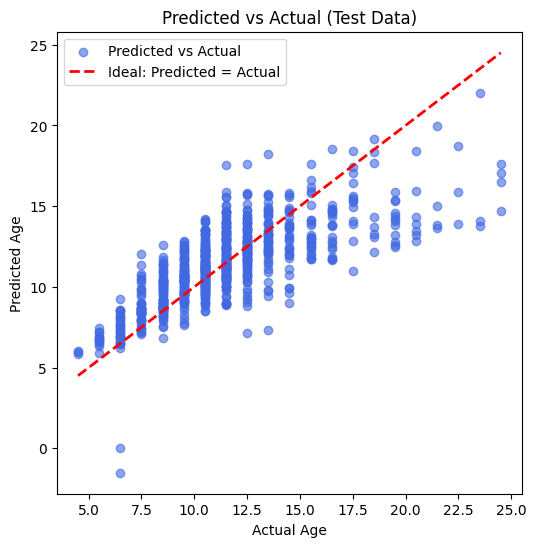

In [10]:
import matplotlib.pyplot as plt

os.makedirs(os.path.join(output_path, 'lin_reg'), exist_ok=True)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_unscaled, y_predict_unscaled,
             alpha=0.6, color='royalblue', label='Predicted vs Actual')
plt.plot(
    [min(y_test_unscaled), max(y_test_unscaled)],
    [min(y_test_unscaled), max(y_test_unscaled)],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Ideal: Predicted = Actual'
)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs Actual (Test Data)')
plt.legend()

plt.savefig(output_path+'/lin_reg/lin_reg_plot.png', dpi=300, bbox_inches='tight')
plt.show()